In [1]:
import pandas as pd
import numpy as np

In [2]:
flats_df = pd.read_csv("SPb/SPb_addr_area_price_lon_lat.csv", sep=",")

In [3]:
flats_df.head()

,address,area,price,longtitude,latitude
0,"Санкт-Петербург, ул. Вадима Шефнера, 10к1",65.0,192308,59.938658,30.205582
1,"Санкт-Петербург, ул. Салова, д. 61, лит. А",37.0,146723,59.885142,30.368554
2,"Санкт-Петербург, ул. Плесецкая, д. 20, корп. 1",24.3,127572,60.039076,30.227959
3,"Санкт-Петербург, Пулковское ш., 38к7",26.8,166045,59.820553,30.327591
4,"Санкт-Петербург, ул. Вадима Шефнера, д. 4",28.0,127709,59.934695,30.208681


In [4]:
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

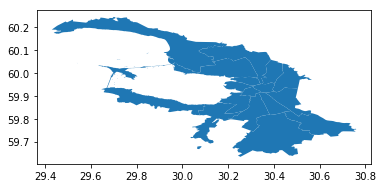

In [5]:
distr_map = gpd.read_file('exportsh/SPb/Saint Petersburg_AL5.shp', encoding="utf-8")
distr_map.plot()

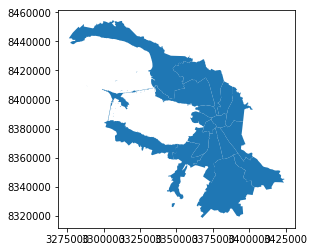

In [6]:
crs = {"init": "epsg:3857"}
distr_map_ep = distr_map.to_crs(crs)
distr_map_ep.plot()

In [7]:
points = [Point(xy) for xy in zip(flats_df.latitude.astype(float), flats_df.longtitude.astype(float))]
crs = {'init' :'epsg:4326'}
flats_geo = GeoDataFrame(flats_df, geometry=points, crs=crs)
flats_geo_ep = flats_geo.to_crs({"init": "epsg:3857"})

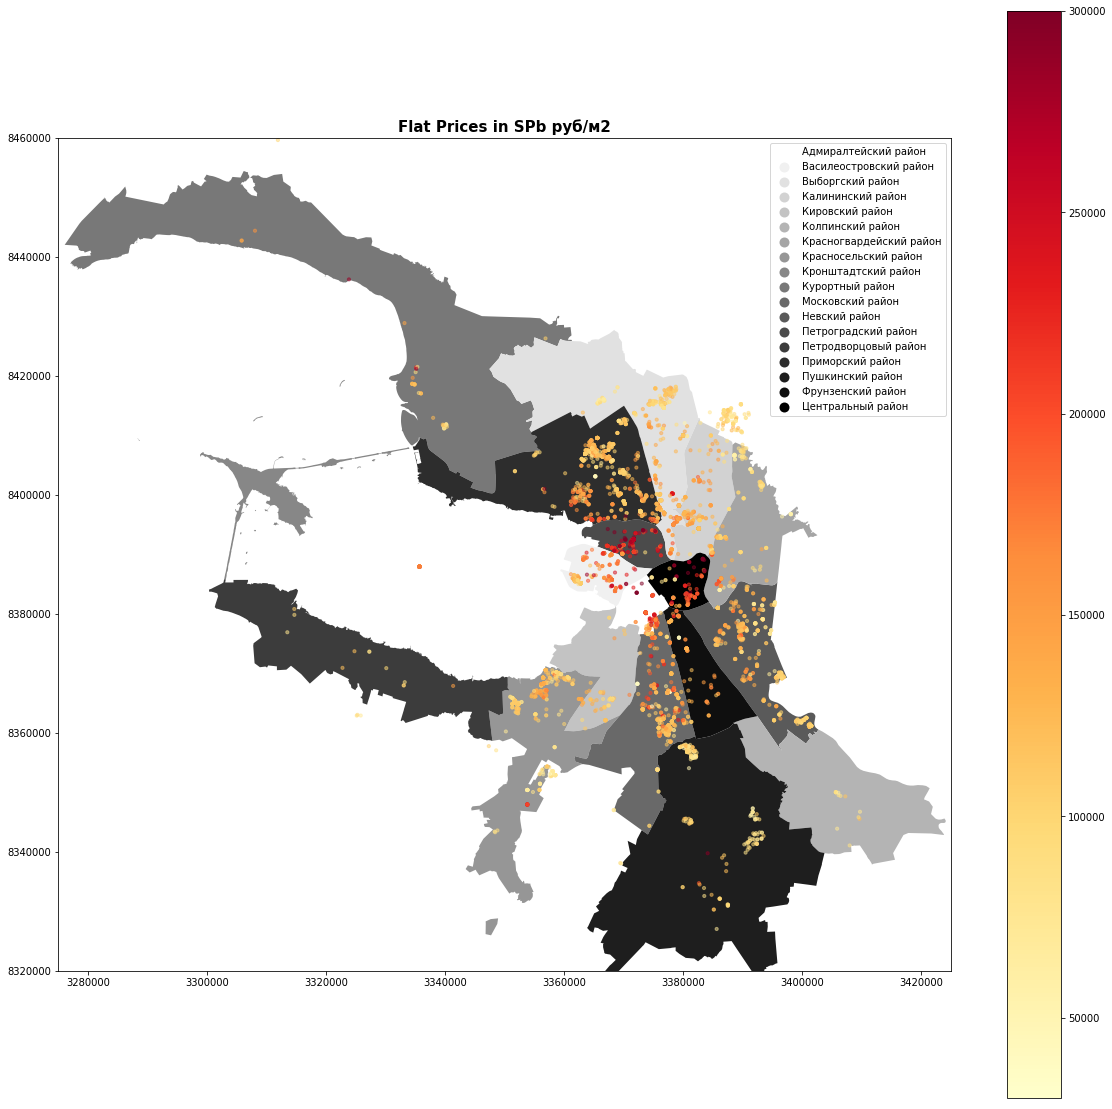

In [8]:
fig, ax = plt.subplots(figsize=(20,20))
distr_map_ep.plot(ax=ax, column = 'locname', linewidth=0.5, cmap='binary', legend=True)
flats_geo_ep.plot(column="price",ax=ax, alpha=0.5, legend=True, markersize=10, cmap="YlOrRd", vmin=30000, vmax=300000)
plt.title("Flat Prices in SPb руб/м2", fontsize=15, fontweight="bold")
plt.ylim(8320000,8460000)
plt.xlim( 3275000,3425000)
plt.show()

In [9]:
count_price = {}

for point in flats_geo.geometry:    
    for i, geometry in enumerate(distr_map.geometry):
        if point.within(geometry):
            if count_price.get(distr_map.locname[i], None) is None:
                count_price[distr_map.locname[i]] = [flats_geo.price[i]]
            else:
                count_price[distr_map.locname[i]].append(flats_geo.price[i])

In [10]:
from functools import reduce

aver_price = {}
for k, lst in count_price.items():
    aver_price[k] = reduce(lambda a, b: a + b, lst) / len(lst) 
    
#aver_price

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 <a list of 17 Text xticklabel objects>)

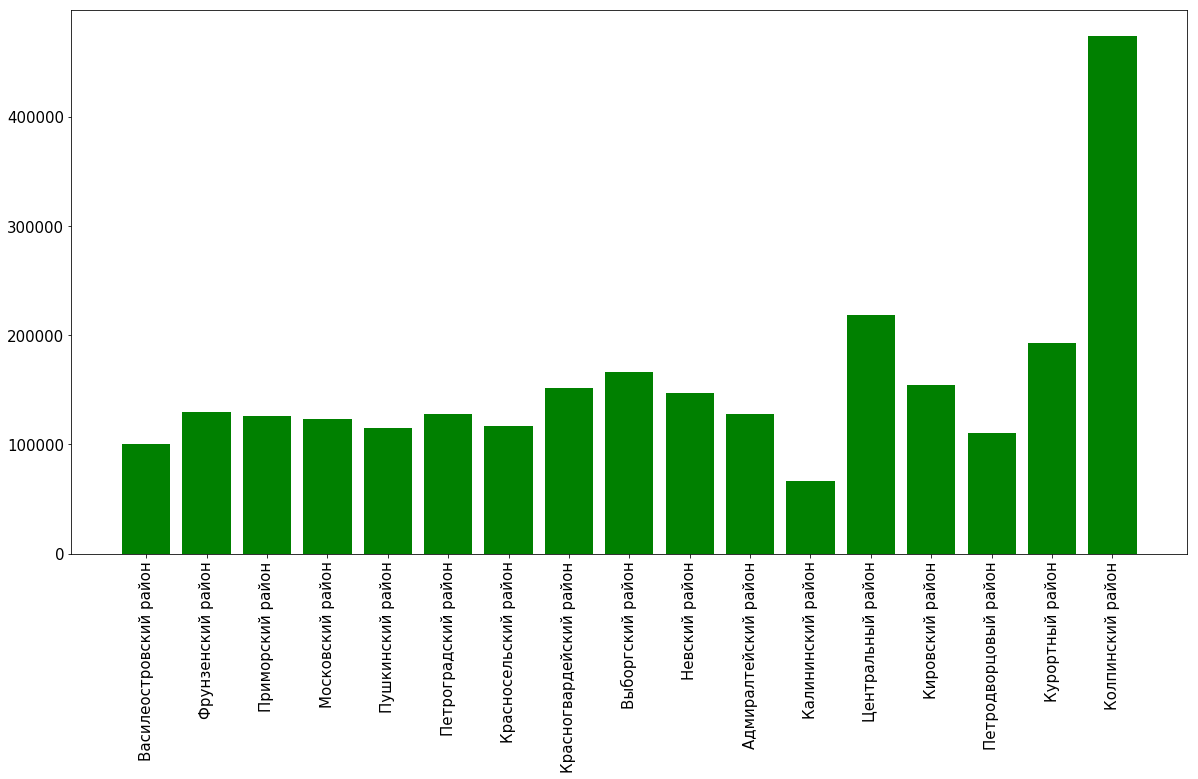

In [11]:
plt.figure(figsize=(20,10))
plt.bar(aver_price.keys(), aver_price.values(), color='g')
plt.tick_params(labelsize=15)
plt.xticks(rotation=90)

In [12]:
#  Визуализация по средней площади квартиры

In [13]:
count_area = {}

for point in flats_geo.geometry:    
    for i, geometry in enumerate(distr_map.geometry):
        if point.within(geometry):
            if count_area.get(distr_map.locname[i], None) is None:
                count_area[distr_map.locname[i]] = [flats_geo["area"][i]]
            else:
                count_area[distr_map.locname[i]].append(flats_geo["area"][i])

In [14]:
aver_area = {}

for k, lst in count_area.items():
    aver_area[k] = reduce(lambda a, b: a + b, lst) / len(lst) 
    
#aver_area

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 <a list of 17 Text xticklabel objects>)

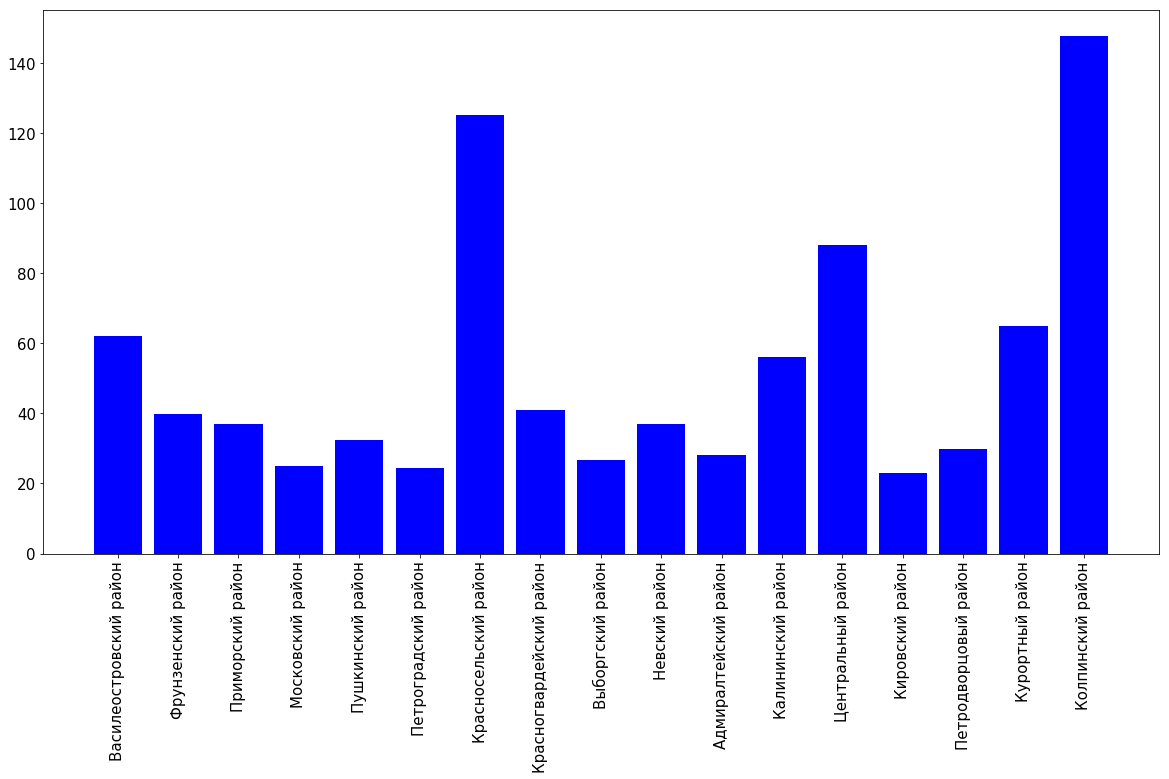

In [15]:
plt.figure(figsize=(20,10))
plt.bar(aver_area.keys(), aver_area.values(), color='b')
plt.tick_params(labelsize=15)
plt.xticks(rotation=90)

In [16]:
# Визуализация с помощью folium

In [17]:
import folium
from folium import plugins
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster

In [18]:
def data_unq(df):
    l_addr = len(df.address.unique())
    l_lon = len(df.longtitude.unique())
    l_lat = len(df.latitude.unique())
    l_price = len(df.price.unique())
    print(f"l_addr: {l_addr}, l_lon: {l_lon}, l_lat: {l_lat}, l_price: {l_price}")

data_unq(flats_df)

l_addr: 2050, l_lon: 1388, l_lat: 1389, l_price: 4326


In [19]:
max_price = float(flats_df.price.max())
min_price = float(flats_df.price.min())
max_price, min_price

(812923.0, 28209.0)

In [20]:
location = [59.960183, 30.345809]
mymap = folium.Map(location=location, zoom_start=10)
mc = MarkerCluster()
lon, lat = 'longtitude', 'latitude'
price, address = "price", "address"

for _, row in flats_df.iterrows():
    info = f"Адрес: {row[address]}, Стоимость:{row[price]} руб/м2"
    mc.add_child(folium.Marker(location=[row[lon], row[lat]], popup=info))
    mymap.add_child(mc)
#mymap

In [21]:
lon = flats_df.longtitude.values.astype(float)
lat = flats_df.latitude.values.astype(float)
price = flats_df.price.values.astype(float)
lat, lon, price
l_data = list(zip(lon, lat, price))
#l_data

In [22]:
hmap = HeatMap(l_data, min_opacity=0.2, max_val=max(price), radius=10, blur=10, max_zoom=1,)
hmap.add_to(mymap)
#mymap

In [23]:
import os
mymap.save(os.path.join('SPb/', 'heatmap.html'))